# Recurrent Neural Networks for Time Series Forecasting: LTSM, GRU, Vanilla
## wrapped by the Darts multi-method package for time series analysis

In [1]:
EPOCH = 3       # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import darts

import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = '2021-12-31 23:00:00'   # period at which to split training and validation dataset


/home/bhavya/Desktop/amol/test/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=pd.read_csv('merged_data.csv')
sample=df[(df['mkt_datetime']>='2022-06-01 00:00:00') & (df['mkt_datetime']<'2022-09-01 00:00:00')].reset_index()

<AxesSubplot:xlabel='mkt_datetime'>

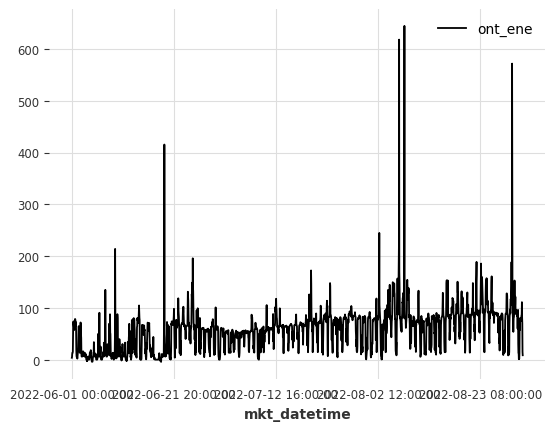

In [4]:
sample.plot(x='mkt_datetime',y='ont_ene')

In [5]:
sample_ts=darts.timeseries.TimeSeries.from_dataframe(sample,time_col='mkt_datetime',value_cols='ont_ene')

In [6]:
is_seasonal, periodicity = check_seasonality(sample_ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (hours)":f'{periodicity}', 
    "periodicity (~days)": f'{periodicity/24:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (hours) : 24
periodicity (~days) : 1.0


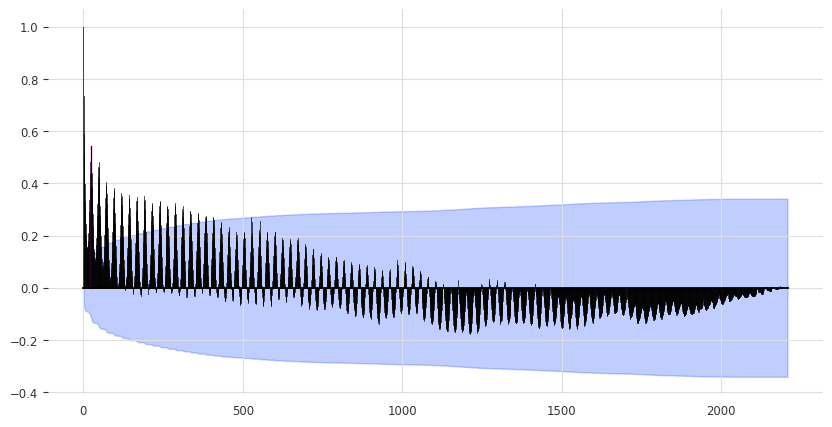

In [7]:
# plot its autocorrelation function
plot_acf(sample_ts, periodicity, max_lag=len(sample_ts)-1)

In [8]:
df_ts=darts.timeseries.TimeSeries.from_dataframe(df,time_col='mkt_datetime')

In [13]:
series=df_ts

In [9]:
# split training vs test dataset
train, val = df_ts.split_after(pd.Timestamp(FC_START))

In [10]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
df_ts_trf = trf.transform(df_ts)

In [11]:
df_ts.freq

<Hour>

In [20]:
# create month and year covariate series

day_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=df_ts.freq_str, 
        periods=20000),
    attribute='day', 
    one_hot=False)
day_series = Scaler().fit_transform(day_series)

hour_series = datetime_attribute_timeseries(
    day_series, 
    attribute='hour', 
    one_hot=True)

covariates = day_series.stack(hour_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

In [27]:
df_ts.freq_str

'H'

# Run the RNN Models

In [21]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [22]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [23]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [24]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]
    

In [26]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, df_ts_trf, train_trf, val_trf) for flv in flavors]


beginning the training of the LSTM RNN:
Sanity Checking: 0it [00:00, ?it/s]

ValueError: Missing covariates; could not find past covariates in index value range: 2022-09-08 03:00:00 - 2022-09-08 22:00:00.